<a href="https://www.kaggle.com/code/mirabirhossain/model-from-scratch?scriptVersionId=145258086" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this notebook we will build a CNN model from scratch for our mangoleafbd dataset. We are going to use PyTorch framework.

In [1]:
!pip install torchsummary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as f
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First we will set the seed. This will ensure that all the following code is reproducable.

In [3]:
# Setting the seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Now let us save the path of the train and test data into two separate variable

In [4]:
# Train and Test data directory
train_data_dir = '/kaggle/input/mangoleafbdomdena/MangoLeafBDomdena/Train'
test_data_dir = '/kaggle/input/mangoleafbdomdena/MangoLeafBDomdena/Test'

We are going to use some augmentation on the training data set. It will help us to make the dataset more diverse and thus challenge the model to learn more things. 

We will use random horizontal and vertical flip 30% of the time.


Besides, we will resize all our image to (224, 224) in both train and test set 

Also we will normalize the image with 0.5 mean and 0.5 standard deviation in both train and test set.

In [5]:
# Defining the augmentation for train and test data

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Now we will use the `ImageFolder` class from pytorch to create the dataset from the existing folder. This `ImageFolder` class from PyTorch can take any data folder full of image and convert it to dataset format for further tasks.

In [6]:
# Creating the PyTorch Dataset from train and test directory cause

train_dataset = ImageFolder(train_data_dir, transform=train_transform)
test_dataset = ImageFolder(test_data_dir, transform=test_transform)

In [7]:
# Checking the length of the train and test dataset
len(train_dataset), len(test_dataset)

(3299, 379)

We have train and test dataset but we do not have any validation dataset. So, we are going to split the train dataset into train and validation set. We are going to make sure that the split is done properly through all the classes.

In [8]:
# Dividing the train data into train set and validation set
# Creating train and validation indices
# using "stratify" is making sure that every class gets equal portion of indices while spliting

train_indices, valid_indices = train_test_split(range(len(train_dataset)), test_size=0.1,
                                               stratify=train_dataset.targets,
                                               random_state=42)

Now we will create train, valid and test dataloader. Dataloaders are batch of data that will be fed to the model while training.

In [9]:
# Using the train and validation indices to randomly sample them for train and validation set
train_sampler = data.SubsetRandomSampler(train_indices)
valid_sampler = data.SubsetRandomSampler(valid_indices)

# Creating PyTorch DataLoaders to divide the dataset into batches to feed the model
# Models built in PyTorch can only take data from DataLoaders
trainloader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
validloader = DataLoader(train_dataset, batch_size=64, sampler=valid_sampler)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Here we are creating the model from scratch. The following architecture is the final version of the model. We have done some trial and errors and tweaked the architecture a while before reaching the final version.

In [10]:
# Designing the model
# This is the final model after some training and parameter tuning

# Depthwise Separable Convolution block
class DSCBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool='max'):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        if pool == 'max':
            self.pooling = nn.MaxPool2d(2, 2)
        elif pool == 'avg':
            self.pooling = nn.AvgPool2d(13, 13)
    
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        return x
        
# Full architecture using the Depthwise Separable Convolution blocks
class CNNarch(nn.Module):
    def __init__(self, block):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 111
            block(32, 64), # 55
            block(64, 128), # 27
            block(128, 256), # 13
            block(256, 256, 'avg'), 
        )
        
        self.linear = nn.Sequential(
            nn.Linear(256, 48),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(48, 8)
        )
        
    def forward(self, x):
        x = self.blocks(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
        

Let us look at the summary of the model

In [11]:
# Creating a instance of model to use the torchsummary to see the summary of the model
model = CNNarch(DSCBlock).to(device)
m1 = model(torch.randn(1, 3, 224, 224).to(device))
print(summary(model, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
       BatchNorm2d-2         [-1, 32, 222, 222]              64
              ReLU-3         [-1, 32, 222, 222]               0
         MaxPool2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 111, 111]             320
            Conv2d-6         [-1, 64, 111, 111]           2,112
       BatchNorm2d-7         [-1, 64, 111, 111]             128
              ReLU-8         [-1, 64, 111, 111]               0
         MaxPool2d-9           [-1, 64, 55, 55]               0
         DSCBlock-10           [-1, 64, 55, 55]               0
           Conv2d-11           [-1, 64, 55, 55]             640
           Conv2d-12          [-1, 128, 55, 55]           8,320
      BatchNorm2d-13          [-1, 128, 55, 55]             256
             ReLU-14          [-1, 128,

**From above, the model has 129,144 parameters, which is very lightweight and parameter size is only 0.49MB**

Our dataset is slightly imbalanced. It is better that we use proper class weight. The following code computes the class weight for each class. We will use these values while training the model

In [12]:
# Creating class weights because in the dataset there is class imbalance

class_weights = []

total_samples = len(trainloader.dataset)
num_classes = len(trainloader.dataset.classes)

for class_idx in range(num_classes):
    class_count = torch.sum(torch.tensor(trainloader.dataset.targets) == class_idx)
    class_weight = total_samples / (num_classes * class_count)
    class_weights.append(class_weight)

class_weights = torch.FloatTensor(class_weights).to(device)

# We can see the class weights in the output cell
print(class_weights)

tensor([0.9635, 0.9502, 1.8744, 0.9436, 0.9546, 0.9164, 0.9205, 0.9164],
       device='cuda:0')


Now let us define the loss function and the algorithm for training. We are going to use `cross entropy loss` as the loss function and `Adam` as the learning algorithm.

In [13]:
# Defining the Loss function and the algorithm for model training
# Cross Entropy Loss as loss function and Adam as optimizer

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.005)

After some analysis we found out training for 40 epochs is optimal with the above setting. Let us train the model.

In [14]:
# Training the model for 40 epochs with learning rate of 0.005

num_epochs = 40

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, targets in tqdm(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(validloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += targets.size(0)
            correct_valid += (predicted == targets).sum().item()
    
    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(valid_accuracy)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Training Loss: {train_losses[-1]:.4f} | Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {valid_losses[-1]:.4f} | Validation Accuracy: {valid_accuracy:.2f}%')




100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch [1/40]
Training Loss: 1.1472 | Training Accuracy: 55.37%
Validation Loss: 0.5600 | Validation Accuracy: 79.39%


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Epoch [2/40]
Training Loss: 0.6306 | Training Accuracy: 76.42%
Validation Loss: 1.2844 | Validation Accuracy: 61.21%


100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


Epoch [3/40]
Training Loss: 0.5027 | Training Accuracy: 81.44%
Validation Loss: 0.6616 | Validation Accuracy: 73.94%


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Epoch [4/40]
Training Loss: 0.5224 | Training Accuracy: 82.72%
Validation Loss: 0.9125 | Validation Accuracy: 71.82%


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Epoch [5/40]
Training Loss: 0.4154 | Training Accuracy: 85.15%
Validation Loss: 0.3404 | Validation Accuracy: 90.00%


100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


Epoch [6/40]
Training Loss: 0.3659 | Training Accuracy: 87.67%
Validation Loss: 0.3172 | Validation Accuracy: 85.76%


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Epoch [7/40]
Training Loss: 0.3696 | Training Accuracy: 87.61%
Validation Loss: 1.9987 | Validation Accuracy: 55.76%


100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Epoch [8/40]
Training Loss: 0.3354 | Training Accuracy: 87.44%
Validation Loss: 0.2775 | Validation Accuracy: 90.30%


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Epoch [9/40]
Training Loss: 0.3660 | Training Accuracy: 86.83%
Validation Loss: 0.2259 | Validation Accuracy: 90.91%


100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


Epoch [10/40]
Training Loss: 0.2789 | Training Accuracy: 89.19%
Validation Loss: 0.2142 | Validation Accuracy: 93.03%


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Epoch [11/40]
Training Loss: 0.2536 | Training Accuracy: 90.74%
Validation Loss: 0.3361 | Validation Accuracy: 88.79%


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Epoch [12/40]
Training Loss: 0.2647 | Training Accuracy: 90.60%
Validation Loss: 0.2927 | Validation Accuracy: 90.00%


100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


Epoch [13/40]
Training Loss: 0.2675 | Training Accuracy: 90.54%
Validation Loss: 0.1740 | Validation Accuracy: 94.85%


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


Epoch [14/40]
Training Loss: 0.2388 | Training Accuracy: 92.15%
Validation Loss: 1.1033 | Validation Accuracy: 75.15%


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Epoch [15/40]
Training Loss: 0.2677 | Training Accuracy: 90.03%
Validation Loss: 0.5373 | Validation Accuracy: 87.58%


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Epoch [16/40]
Training Loss: 0.2566 | Training Accuracy: 90.20%
Validation Loss: 0.1100 | Validation Accuracy: 96.36%


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Epoch [17/40]
Training Loss: 0.1908 | Training Accuracy: 93.63%
Validation Loss: 0.1087 | Validation Accuracy: 96.36%


100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


Epoch [18/40]
Training Loss: 0.1742 | Training Accuracy: 94.00%
Validation Loss: 0.1159 | Validation Accuracy: 97.88%


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Epoch [19/40]
Training Loss: 0.2144 | Training Accuracy: 93.03%
Validation Loss: 0.1019 | Validation Accuracy: 98.48%


100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


Epoch [20/40]
Training Loss: 0.1766 | Training Accuracy: 94.00%
Validation Loss: 0.2694 | Validation Accuracy: 89.09%


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Epoch [21/40]
Training Loss: 0.1925 | Training Accuracy: 93.47%
Validation Loss: 0.0197 | Validation Accuracy: 99.09%


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Epoch [22/40]
Training Loss: 0.1508 | Training Accuracy: 94.44%
Validation Loss: 0.0162 | Validation Accuracy: 99.39%


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Epoch [23/40]
Training Loss: 0.1451 | Training Accuracy: 95.25%
Validation Loss: 0.8361 | Validation Accuracy: 84.85%


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Epoch [24/40]
Training Loss: 0.1535 | Training Accuracy: 94.85%
Validation Loss: 0.2635 | Validation Accuracy: 93.03%


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Epoch [25/40]
Training Loss: 0.1331 | Training Accuracy: 94.98%
Validation Loss: 0.2214 | Validation Accuracy: 95.15%


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Epoch [26/40]
Training Loss: 0.1396 | Training Accuracy: 95.25%
Validation Loss: 0.0305 | Validation Accuracy: 98.48%


100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


Epoch [27/40]
Training Loss: 0.1201 | Training Accuracy: 95.86%
Validation Loss: 0.3996 | Validation Accuracy: 90.61%


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Epoch [28/40]
Training Loss: 0.1042 | Training Accuracy: 96.46%
Validation Loss: 0.0347 | Validation Accuracy: 99.09%


100%|██████████| 6/6 [00:01<00:00,  4.65it/s]


Epoch [29/40]
Training Loss: 0.1509 | Training Accuracy: 94.71%
Validation Loss: 0.1199 | Validation Accuracy: 95.76%


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Epoch [30/40]
Training Loss: 0.1456 | Training Accuracy: 95.15%
Validation Loss: 0.0600 | Validation Accuracy: 97.27%


100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Epoch [31/40]
Training Loss: 0.1332 | Training Accuracy: 95.02%
Validation Loss: 0.0206 | Validation Accuracy: 99.09%


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Epoch [32/40]
Training Loss: 0.1517 | Training Accuracy: 95.05%
Validation Loss: 0.0235 | Validation Accuracy: 99.39%


100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Epoch [33/40]
Training Loss: 0.1388 | Training Accuracy: 94.54%
Validation Loss: 0.0039 | Validation Accuracy: 100.00%


100%|██████████| 6/6 [00:01<00:00,  4.25it/s]


Epoch [34/40]
Training Loss: 0.1035 | Training Accuracy: 96.43%
Validation Loss: 0.0018 | Validation Accuracy: 100.00%


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Epoch [35/40]
Training Loss: 0.1070 | Training Accuracy: 96.26%
Validation Loss: 0.0216 | Validation Accuracy: 99.39%


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Epoch [36/40]
Training Loss: 0.1110 | Training Accuracy: 95.86%
Validation Loss: 0.0574 | Validation Accuracy: 98.79%


100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


Epoch [37/40]
Training Loss: 0.0879 | Training Accuracy: 96.93%
Validation Loss: 0.0294 | Validation Accuracy: 99.09%


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Epoch [38/40]
Training Loss: 0.1331 | Training Accuracy: 95.45%
Validation Loss: 0.1028 | Validation Accuracy: 96.36%


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Epoch [39/40]
Training Loss: 0.1201 | Training Accuracy: 95.96%
Validation Loss: 0.2791 | Validation Accuracy: 92.42%


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]

Epoch [40/40]
Training Loss: 0.1387 | Training Accuracy: 95.66%
Validation Loss: 0.1382 | Validation Accuracy: 94.85%


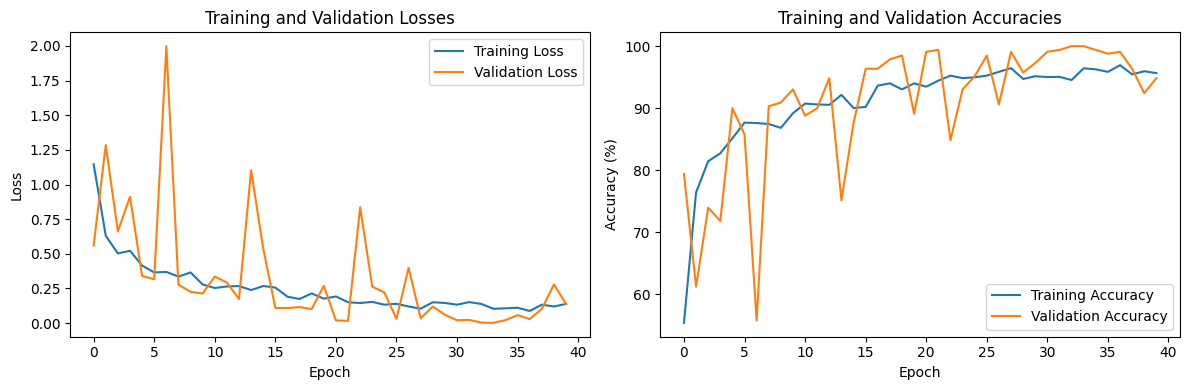

In [15]:
# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

In [16]:
# Evaluating the model performance with the testset
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())




In [17]:
# Calculate and print the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Calculate and print classification report
report = classification_report(y_true, y_pred, target_names=testloader.dataset.classes)
print("Classification Report:")
print(report)

# Calculate and print additional metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[49  0  0  0  1  0  0  0]
 [ 3 46  0  0  0  0  0  0]
 [ 1  0 29  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0]
 [ 0  0  0  0 46  0  1  3]
 [ 0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0 36 14]
 [ 0  0  0  0  0  0  0 50]]
Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.92      0.98      0.95        50
Bacterial Canker       1.00      0.94      0.97        49
  Cutting Weevil       1.00      0.97      0.98        30
        Die Back       1.00      1.00      1.00        50
      Gall Midge       0.98      0.92      0.95        50
         Healthy       1.00      1.00      1.00        50
  Powdary Mildew       0.97      0.72      0.83        50
    Scooty Mould       0.75      1.00      0.85        50

        accuracy                           0.94       379
       macro avg       0.95      0.94      0.94       379
    weighted avg       0.95      0.94      0.94       379

Accuracy: 0.9393
Precision: 0.9502
Recall: 

**As we can see we get a very good accuracy and precision in test set. Precision, recall and accuracy all are pretty solid, more than 94%. Which is a very good result, considering the size of our model, that is around 134k parameters. Most pretrained models are way bigger than this model containing 10s of millions of paramters. This result shows that this dataset does not need a big model.**

Let us save the model now.

In [18]:
# Saving the model and the weights
torch.save(model, 'full_model.pth')
torch.save(model.state_dict(), 'model.pth')

In [19]:
# Checking the model size

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def model_size_mb(model):
    total_params = count_parameters(model)
    model_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    model_size_mb = model_size_bytes / (1024 * 1024)  # Convert to megabytes (MB)
    return model_size_mb

size_mb = model_size_mb(model)

print(f"Model size: {size_mb:.2f} MB")

Model size: 0.49 MB


**As we can see, we have a very light model of only 0.49 MB**

Now let us plot some of the images from the dataset and see what is their actual and predicted labels.

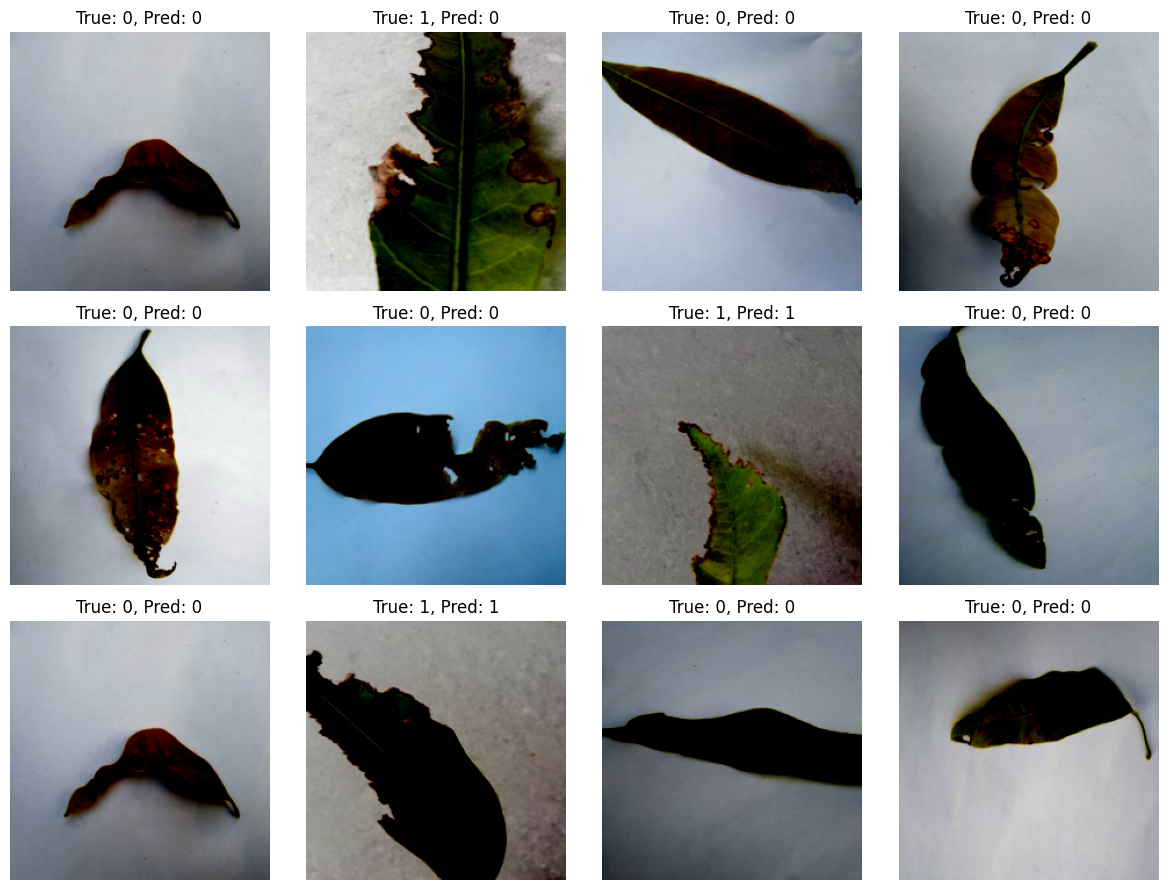

In [20]:
# Testing some random images and plot them to see their acutal label and predicted label

model.eval()

def plot_random_test_samples(model, test_loader, num_samples=12):
    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Move data to GPU
    images = images.to(device)
    labels = labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Plot random samples
    num_rows = 3
    num_cols = 4

    plt.figure(figsize=(12, 9))

    for i in range(num_samples):
        index = np.random.randint(0, images.size(0))
        image = images[index].cpu().numpy()
        label = labels[index].item()
        prediction = predicted[index].item()

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
        plt.title(f"True: {label}, Pred: {prediction}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


plot_random_test_samples(model, testloader, num_samples=12)